# Data preprocessing

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import string
import os
import re
from textblob import TextBlob
from wordcloud import STOPWORDS,WordCloud
from sklearn.model_selection import train_test_split
import gensim
from gensim.models import CoherenceModel
from gensim import corpora
from pprint import pprint
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
import nltk.corpus
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import learning_curve

[nltk_data] Downloading package stopwords to /home/jds98/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
def read_data():
    data = pd.read_csv('processed_tweet_data.csv')
    df = data.copy()
    df = df.drop(['place_coord_boundaries'], axis=1)
    cleanTweet = pd.DataFrame(columns=['text','polarity'])
    cleanTweet['text'] = df['cleaned_text'].to_list()
    cleanTweet['polarity'] = df['polarity'].to_list()
    def text_category(p):
        if p < 0:
            category = 'negative'
        elif p == 0:
            category = 'neutral'
        else:
            category = 'positive'
        return category
    polarities = [TextBlob(t).sentiment.polarity for t in df['original_text'].to_list()]
    scores = [text_category(p) for p in polarities]
    cleanTweet['scores'] = scores
    scoremap = {'positive':1, 'negative':0} 
    cleanTweet['scoremap'] = cleanTweet['scores'].map(scoremap)
    df['scores'] = cleanTweet['scoremap'].to_list()
    df = df.loc[df['scores'].isna() == False]
    df['scores'] = df['scores'].astype('int')
    return df

In [4]:
df = read_data()

In [5]:
class PrepareData:
    def __init__(self,df):
        self.df=df
        
    def created_atProcess(self):
        df['created_at'] = pd.to_datetime(df['created_at'])
        df['time_hour'] = df.created_at.apply(lambda x: x.hour)
        return df
    
    def clean_places(self)->list:
        places = list(df['place'])
        clean_text = []
        for p in places:
            new = p.lower()
            new = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", new)
            stop = stopwords.words('english')
            new = " ".join([word for word in new.split() if word not in (stop)])
            clean_text.append(new)
        df['place'] = clean_text
        
        return df
    
    def hashtagsProcess(self):
        
        def find_hashtags(text):
            '''This function will extract hashtags'''
            return re.findall('(#[A-Za-z]+[A-Za-z0-9-_]+)', text)
        
        # update Hashtage columon with hashtages extracted from Orignal_text columon
        df['hashtags'] = df.original_text.apply(find_hashtags)
        
        # take the rows from the hashtag columns where there are actually hashtags
        hashtags_list_df = df.loc[
                               df.hashtags.apply(
                                   lambda hashtags_list: hashtags_list !=[]
                               ),['hashtags']]        
        flattened_hashtags_df = pd.DataFrame(
            [hashtag for hashtags_list in hashtags_list_df.hashtags
            for hashtag in hashtags_list],
            columns=['hashtag'])
        
        #add flatten_hashtags to tweet_df
        df["flattened_hashtags"]= flattened_hashtags_df
        
        return df
    
    def preprocess_data(self):

        #text Preprocessing
        df['cleaned_text'] = df['cleaned_text'].astype(str)
        df['cleaned_text'] = df['cleaned_text'].apply(lambda x: x.translate(str.maketrans(' ', ' ', string.punctuation)))
        
        #Converting tweets to list of words For feature engineering
        sentence_list = [tweet for tweet in df['cleaned_text']]
        word_list = [sent.split() for sent in sentence_list]
        
        #Create dictionary which contains Id and word 
        word_to_id = corpora.Dictionary(word_list) #generate unique tokens
        #  we can see the word to unique integer mapping
        # print(word_to_id.token2id)
        # using bag of words(bow), we create a corpus that contains the word id and its frequency in each document.
        corpus_1= [word_to_id.doc2bow(tweet) for tweet in word_list]
        # TFIDF

        return word_list, word_to_id, corpus_1

In [6]:
PrepareData_obj = PrepareData(df)

In [7]:
df = PrepareData.hashtagsProcess(df)

In [8]:
word_list ,id2word,corpus=PrepareData_obj.preprocess_data()

In [9]:
id_words = [[(id2word[id], count) for id, count in line] for line in corpus]

In [10]:
df = PrepareData.created_atProcess(df)

## Retain relevant features (fields) and processing continuation

In [11]:
df = df.drop(['created_at', 'source', 'original_text', 'sentiment', 'lang', 'hashtags', 'user_mentions'], axis=1)

In [12]:
df.columns

Index(['cleaned_text', 'polarity', 'subjectivity', 'favorite_count',
       'retweet_count', 'original_author', 'screen_count', 'followers_count',
       'friends_count', 'possibly_sensitive', 'place', 'statuses_count',
       'scores', 'flattened_hashtags', 'time_hour'],
      dtype='object')

## Data imputation and additional data transformation

### Replace missing values with the most frequent value) : place and sensitivity are concerned

In [13]:
df = df.fillna(df.mode().iloc[0])

### Working on place field

In [14]:
df = PrepareData.clean_places(df)

In [15]:
df['place'][df['place'] == ''].value_counts()

    545
Name: place, dtype: int64

In [17]:
df['place'][df['place'] == ''] = None

In [18]:
df['place'].isna().sum()

545

In [19]:
df = df.fillna(df.mode().iloc[0])

### Encodage : flattened_hashtags, sensitivity, etc.

In [20]:
encoder = LabelEncoder()

In [21]:
df['original_author'] = encoder.fit_transform(df['original_author'])
lab_authors = encoder.inverse_transform(df['original_author'])
df['possibly_sensitive'] = encoder.fit_transform(df['possibly_sensitive'])
lab_sensitive = encoder.inverse_transform(df['possibly_sensitive'])
df['place'] = encoder.fit_transform(df['place'])
lab_place = encoder.inverse_transform(df['place'])
df['flattened_hashtags'] = encoder.fit_transform(df['flattened_hashtags'])
lab_hashtags = encoder.inverse_transform(df['flattened_hashtags'])

In [22]:
dic_authors = pd.DataFrame(data= {'Label': list(lab_authors), 'Code': list(df['original_author'])})
dic_sensitve = pd.DataFrame(data= {'Label': list(lab_sensitive), 'Code': list(df['possibly_sensitive'])})
dic_place = pd.DataFrame(data= {'Label': list(lab_place), 'Code': list(df['place'])})
dic_hasgtags = pd.DataFrame(data= {'Label': list(lab_hashtags), 'Code': list(df['flattened_hashtags'])})

# Topic modeling

In [23]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [24]:
pprint(lda_model.print_topics())

[(0,
  '0.068*"amp" + 0.026*"fired" + 0.018*"check" + 0.017*"thing" + '
  '0.017*"easily" + 0.016*"nigerians" + 0.016*"ashawo" + 0.016*"hundeyin" + '
  '0.016*"balogun" + 0.016*"tafa"'),
 (1,
  '0.051*"taiwan" + 0.029*"military" + 0.028*"foreign" + 0.027*"army" + '
  '0.026*"around" + 0.020*"chinas" + 0.019*"peoples" + 0.018*"pla" + '
  '0.018*"chinese" + 0.018*"united"'),
 (2,
  '0.088*"called" + 0.062*"stop" + 0.039*"war" + 0.027*"via" + 0.026*"reuters" '
  '+ 0.020*"china" + 0.019*"youtube" + 0.016*"asia" + 0.015*"make" + '
  '0.014*"g7"'),
 (3,
  '0.092*"taiwan" + 0.040*"china" + 0.032*"missile" + 0.031*"indopacinfo" + '
  '0.030*"chinas" + 0.021*"us" + 0.020*"good" + 0.019*"launches" + '
  '0.019*"infographic" + 0.018*"visit"'),
 (4,
  '0.067*"spokespersonchn" + 0.061*"taiwan" + 0.044*"responsible" + '
  '0.039*"showing" + 0.037*"wwiii" + 0.034*"statedept" + 0.034*"muscles" + '
  '0.034*"stopped" + 0.028*"us" + 0.027*"true"'),
 (5,
  '0.125*"taiwans" + 0.071*"island" + 0.054*"chin

In [25]:
pprint(lda_model.show_topics(formatted=False))

[(0,
  [('amp', 0.06777695),
   ('fired', 0.026111634),
   ('check', 0.018112741),
   ('thing', 0.017155835),
   ('easily', 0.0168146),
   ('nigerians', 0.016111797),
   ('ashawo', 0.016111797),
   ('hundeyin', 0.016111797),
   ('balogun', 0.016111797),
   ('tafa', 0.016111797)]),
 (1,
  [('taiwan', 0.050879728),
   ('military', 0.028734328),
   ('foreign', 0.028334502),
   ('army', 0.02742082),
   ('around', 0.026456382),
   ('chinas', 0.020425873),
   ('peoples', 0.018871896),
   ('pla', 0.01842986),
   ('chinese', 0.01814446),
   ('united', 0.017891727)]),
 (2,
  [('called', 0.08779829),
   ('stop', 0.06158376),
   ('war', 0.03862776),
   ('via', 0.02677382),
   ('reuters', 0.025603654),
   ('china', 0.019617015),
   ('youtube', 0.018687448),
   ('asia', 0.01636551),
   ('make', 0.015017206),
   ('g7', 0.014480103)]),
 (3,
  [('taiwan', 0.091738194),
   ('china', 0.040424135),
   ('missile', 0.03185704),
   ('indopacinfo', 0.030795539),
   ('chinas', 0.02991185),
   ('us', 0.0211797

## Model Analysis

In [26]:
# Compute Perplexity

#It's a measure of how good the model is. The lower the better. Perplexity is a negative value
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  
doc_lda = lda_model[corpus]


# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=word_list, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\n Ldamodel Coherence Score/Accuracy on Tweets: ', coherence_lda)


Perplexity:  -8.58264322832119

 Ldamodel Coherence Score/Accuracy on Tweets:  0.36216942850149764


## Visualize the topics

In [28]:
pyLDAvis.enable_notebook()

LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
pyLDAvis.save_html(LDAvis_prepared, 'lda_result.html')

# Sentiment Analysis

### Vectorization

We’re going to use the LDA model to grab the distribution of the top 10 topics in the tweets. This 10-vector will be our feature vector for supervised classification, with the supervised learning goal being to determine positive or negative sentiment.

In [29]:
processed_text = df['cleaned_text']

In [30]:
vecs = []
for i in range(len(processed_text)):
    top_topics = lda_model.get_document_topics(corpus[i], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(10)]
    vecs.append(topic_vec)

In [31]:
X = vecs
y = df['scores']

### Use train_test_split function to construct (X_train, y_train) and (X_test, y_test) from (X,y)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [33]:
model = RandomForestClassifier(n_estimators=200, random_state=0)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=0)

In [34]:
print('train score:', model.score(X_train, y_train))
print('test score:', model.score(X_test, y_test))

train score: 1.0
test score: 0.9004994237418363


### Note: Probable futur performance is 90%

## Predictions

In [35]:
predictions = model.predict(X_test)

In [36]:
predictions[:10]

array([1, 1, 0, 1, 0, 1, 0, 1, 1, 1])

## Confusion matrix

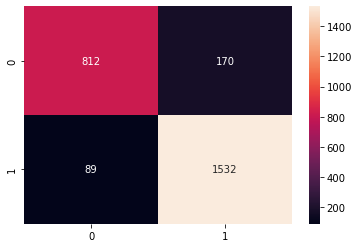

In [40]:
plt.figure()
sns.heatmap(confusion_matrix(y_test, model.predict(X_test)), annot=True, fmt='d')
plt.savefig('confusion matrix.png')

In [38]:
print(812/982)
print(1532/1621)

0.8268839103869654
0.9450956199876619


### Note: The model as well predict 82.69% of the negative sentiments and 94.5% of the positive sentiments

## Learning curve

[ 832 1665 2498 3331 4164 4997 5830 6663 7496 8329]


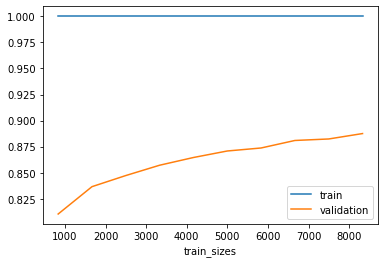

In [39]:
N, train_score, val_score = learning_curve(model, X_train, y_train,
                                           train_sizes=np.linspace(0.1, 1, 10), cv=5)

print(N)
plt.figure()
plt.plot(N, train_score.mean(axis=1), label='train')
plt.plot(N, val_score.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()
plt.savefig('learning curve.png')